In [1]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import xarray as xr
import pandas as pd
import os
import sys
import seaborn as sns
import random 
import scipy as sc
import statsmodels.api as sm
import scipy.stats as stats
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy as cp
import stormeunice as eun
import multiprocessing
import glob
import dask

sys.path.append('/home/e/ermis/moarpalettes')
from moarpalettes import get_palette

sns.set_theme(style="white")
sns.set_style("white")
%matplotlib inline

random.seed(10)

# Data import and pre-processing

In [2]:
# Import track data
P1 = multiprocessing.Pool(40)
ifs_tracks = P1.map(eun.lagrangian.Lagrange.import_medr_tracks_TE, 
                    glob.glob('/home/l/leach/Attribution/NA-Storms/Nick/Scripts/tracking/TE/TEStitch_[!2]*'))
P1.close()

ifs_tracks = pd.concat(ifs_tracks)
ifs_tracks['date'] = pd.to_datetime(ifs_tracks.loc[:,['year','month','day','hour']])

# add era track in
era_track = pd.read_csv('/home/l/leach/Attribution/NA-Storms/Nick/Scripts/tracking/TE/TEStitch_2022_0',
                        skipinitialspace=True)

era_track['expid'] = 'era5'
era_track['experiment'] = 'era5'
era_track['inidate'] = pd.to_datetime('2022-01-01')
era_track['number'] = 0
era_track['date'] = pd.to_datetime(era_track.loc[:,['year','month','day','hour']])

all_tracks = pd.concat([ifs_tracks,era_track])

eunice_track = era_track.query('track_id==5')

In [3]:
ifs_tracks_filter = ifs_tracks.groupby(['track_id','inidate','experiment','number']).agg(dict(date=min, day=np.size, lon=lambda x: x.iloc[0], lat=lambda x: x.iloc[0], msl=min))
eunice_filter = eunice_track.groupby(['track_id','inidate','experiment','number']).agg(dict(date=min, day=np.size, lon=lambda x: x.iloc[0], lat=lambda x: x.iloc[0], msl=min)).iloc[0]

# starttime criterion - must be detected within 12 hours (before or after) the ERA5 track detectino time
starttime_crit = (ifs_tracks_filter.date - eunice_filter.date).dt.total_seconds().abs()<(12*60*60)
# starting location criterion - must start within 10 degrees of the ERA5 track starting point
startloc_crit = np.sqrt((ifs_tracks_filter.lon-eunice_filter.lon)**2+(ifs_tracks_filter.lat-eunice_filter.lat)**2)<10
# depth criterion - must reach a depth of at least 980 hPa
minmsl_crit = ifs_tracks_filter.msl < 98000

ifs_tracks_filtered = ifs_tracks_filter.loc[starttime_crit&startloc_crit&minmsl_crit]
ifs_eunice_list = ifs_tracks.set_index(['track_id','inidate','experiment','number']).sort_index().loc[ifs_tracks_filtered.index].reset_index()

In [4]:
# For members with more than one Eunice-like track: keep the ones with the longest track? 
multi_track_members = ifs_eunice_list.groupby(['inidate','experiment','number','track_id']).agg(dict(year = lambda x: 1)).groupby(['inidate','experiment','number']).count().query('year > 1')

for idx in multi_track_members.index:
    track_dists = ifs_eunice_list.query('inidate=="{}" & experiment=="{}" & number=={}'.format(*idx)).groupby('track_id').apply(lambda x: eun.lagrangian.Lagrange.eunice_dist(x,eunice_track=eunice_track))
    num_reject = track_dists.idxmax()
    ifs_eunice_list_idx = ifs_eunice_list.query('inidate=="{}" & experiment=="{}" & number=={} & track_id=={}'.format(*idx,num_reject)).index
    ifs_eunice_list = ifs_eunice_list.drop(ifs_eunice_list_idx)

In [5]:
ERA5_tracks = pd.read_hdf('/gf3/predict2/AWH012_LEACH_NASTORM/DATA/postproc/tracks/ERA5/EU025/sfc/2022.h5')
ERA5_eunice_track = ERA5_tracks.query('uid=="202202079"')

ERA5_data = xr.open_dataset('/gf3/predict2/AWH012_LEACH_NASTORM/DATA/ERA5/EU025/sfc/2022.nc').sel(time=ERA5_eunice_track.date.values)
ERA5_data['centroid_lon'] = ('time',(ERA5_eunice_track.long*4).round()/4)
ERA5_data['centroid_lat'] = ('time',(ERA5_eunice_track.lat*4).round()/4)

ERA5_eunice_stormframe = ERA5_data.groupby('time').apply(eun.lagrangian.Lagrange.lagrangian_frame)

In [6]:
%%capture 
# Ignore outputs

# Import field data, Lagrangian fram
curr_storms = xr.open_mfdataset('/gf3/predict2/AWH012_LEACH_NASTORM/DATA/MED-R/ENS/EU025/sfc/pf/*.nc',
                                preprocess=lambda x: eun.lagrangian.Lagrange.preproc_to_stormframe(x, ifs_eunice_list=ifs_eunice_list),
                                combine='nested',
                                concat_dim=['inidate'],
                                parallel=True, 
                                engine='netcdf4')
pi_storms = xr.open_mfdataset('/gf3/predict2/AWH012_LEACH_NASTORM/DATA/MED-R/EXP/pi/EU025/sfc/pf/*.nc',
                              preprocess=lambda x: eun.lagrangian.Lagrange.preproc_to_stormframe(x, ifs_eunice_list=ifs_eunice_list),
                              combine='nested',
                              concat_dim=['inidate'],
                              parallel=True, 
                              engine='netcdf4')
incr_storms = xr.open_mfdataset('/gf3/predict2/AWH012_LEACH_NASTORM/DATA/MED-R/EXP/incr/EU025/sfc/pf/*.nc',
                                preprocess=lambda x: eun.lagrangian.Lagrange.preproc_to_stormframe(x, ifs_eunice_list=ifs_eunice_list),
                                combine='nested',
                                concat_dim=['inidate'],
                                parallel=True, 
                                engine='netcdf4')

# Surface Lagrangians

## Wind speeds

/tmp/user/27529/ipykernel_3577161/725863613.py:3: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  cplot.axes[0,0].set_title('8 days lead')
/tmp/user/27529/ipykernel_3577161/725863613.py:4: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  cplot.axes[0,1].set_title('4 days lead')
/tmp/user/27529/ipykernel_3577161/725863613.py:5: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  cplot.axes[0,2].set_title('2 days lead')
/tmp/user/27529/ipykernel_3577161/725863613.py:7: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  cplot.axes[0,0].set_xlabel('lon from storm centre')
/tmp/user/27529/ipykernel_3577161/725863613.py:8: DeprecationWarning: self.axes is deprecated since 2

Text(74.0, 0.5, 'lat from storm centre')

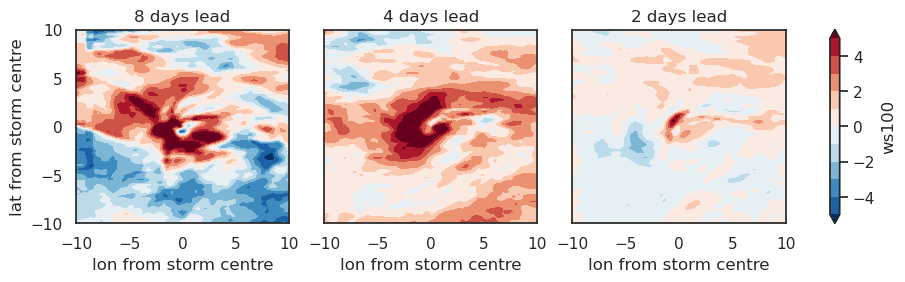

In [11]:
cplot = (incr_storms.ws100.sel(timestep=0).mean('number').squeeze() - pi_storms.ws100.sel(timestep=0).mean('number').squeeze()).sortby('inidate').plot.contourf(col='inidate',levels=np.linspace(-5,5,11))

cplot.axes[0,0].set_title('8 days lead')
cplot.axes[0,1].set_title('4 days lead')
cplot.axes[0,2].set_title('2 days lead')

cplot.axes[0,0].set_xlabel('lon from storm centre')
cplot.axes[0,1].set_xlabel('lon from storm centre')
cplot.axes[0,2].set_xlabel('lon from storm centre')
cplot.axes[0,0].set_ylabel('lat from storm centre')

## SST one day before vorticity maximum

/tmp/user/27529/ipykernel_3577161/539250323.py:3: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  cplot.axes[0,0].set_title('8 days lead')
/tmp/user/27529/ipykernel_3577161/539250323.py:4: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  cplot.axes[0,1].set_title('4 days lead')
/tmp/user/27529/ipykernel_3577161/539250323.py:5: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  cplot.axes[0,2].set_title('2 days lead')
/tmp/user/27529/ipykernel_3577161/539250323.py:7: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  cplot.axes[0,0].set_xlabel('lon from storm centre')
/tmp/user/27529/ipykernel_3577161/539250323.py:8: DeprecationWarning: self.axes is deprecated since 2

Text(74.0, 0.5, 'lat from storm centre')

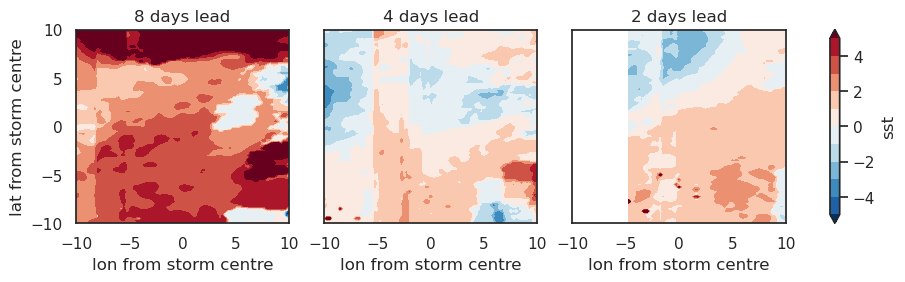

In [12]:
cplot = (incr_storms.sst.sel(timestep=-1).mean('number').squeeze() - pi_storms.sst.sel(timestep=-1).mean('number').squeeze()).sortby('inidate').plot.contourf(col='inidate',levels=np.linspace(-5,5,11))

cplot.axes[0,0].set_title('8 days lead')
cplot.axes[0,1].set_title('4 days lead')
cplot.axes[0,2].set_title('2 days lead')

cplot.axes[0,0].set_xlabel('lon from storm centre')
cplot.axes[0,1].set_xlabel('lon from storm centre')
cplot.axes[0,2].set_xlabel('lon from storm centre')
cplot.axes[0,0].set_ylabel('lat from storm centre')

# Composites at maximum deepening

In [9]:
%%capture 
# Ignore outputs

# Import field data, Lagrangian fram
curr_storms = xr.open_mfdataset('/gf3/predict2/AWH012_LEACH_NASTORM/DATA/MED-R/ENS/EU025/sfc/pf/*.nc',
                                preprocess=lambda x: eun.lagrangian.Lagrange.preproc_to_stormframe_max_deepening(x, ifs_eunice_list=ifs_eunice_list),
                                combine='nested',
                                concat_dim=['inidate'],
                                parallel=True, 
                                engine='netcdf4')
pi_storms = xr.open_mfdataset('/gf3/predict2/AWH012_LEACH_NASTORM/DATA/MED-R/EXP/pi/EU025/sfc/pf/*.nc',
                              preprocess=lambda x: eun.lagrangian.Lagrange.preproc_to_stormframe_max_deepening(x, ifs_eunice_list=ifs_eunice_list),
                              combine='nested',
                              concat_dim=['inidate'],
                              parallel=True, 
                              engine='netcdf4')
incr_storms = xr.open_mfdataset('/gf3/predict2/AWH012_LEACH_NASTORM/DATA/MED-R/EXP/incr/EU025/sfc/pf/*.nc',
                                preprocess=lambda x: eun.lagrangian.Lagrange.preproc_to_stormframe_max_deepening(x, ifs_eunice_list=ifs_eunice_list),
                                combine='nested',
                                concat_dim=['inidate'],
                                parallel=True, 
                                engine='netcdf4')

## Total column water vapour

/tmp/user/27529/ipykernel_3577161/385924748.py:3: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  cplot.axes[0,0].set_title('8 days lead')
/tmp/user/27529/ipykernel_3577161/385924748.py:4: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  cplot.axes[0,1].set_title('4 days lead')
/tmp/user/27529/ipykernel_3577161/385924748.py:5: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  cplot.axes[0,2].set_title('2 days lead')
/tmp/user/27529/ipykernel_3577161/385924748.py:7: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  cplot.axes[0,0].set_xlabel('lon from storm centre')
/tmp/user/27529/ipykernel_3577161/385924748.py:8: DeprecationWarning: self.axes is deprecated since 2

Text(74.0, 0.5, 'lat from storm centre')

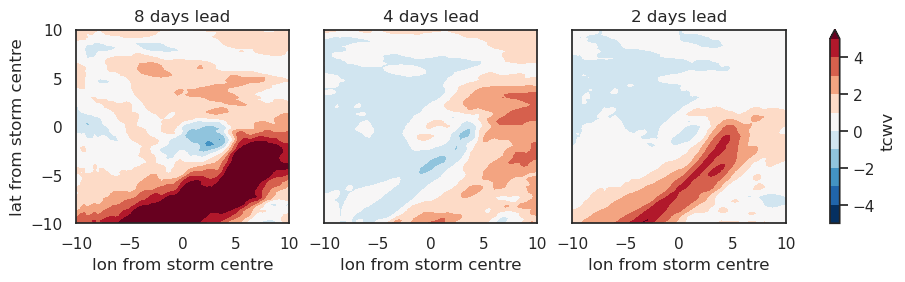

In [13]:
cplot = (incr_storms.tcwv.sel(timestep=0).mean('number').squeeze() - pi_storms.tcwv.sel(timestep=0).mean('number').squeeze()).sortby('inidate').plot.contourf(col='inidate',levels=np.linspace(-5,5,11))

cplot.axes[0,0].set_title('8 days lead')
cplot.axes[0,1].set_title('4 days lead')
cplot.axes[0,2].set_title('2 days lead')

cplot.axes[0,0].set_xlabel('lon from storm centre')
cplot.axes[0,1].set_xlabel('lon from storm centre')
cplot.axes[0,2].set_xlabel('lon from storm centre')
cplot.axes[0,0].set_ylabel('lat from storm centre')

## Precipitation 

/tmp/user/27529/ipykernel_3577161/3067089035.py:3: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  cplot.axes[0,0].set_title('8 days lead')
/tmp/user/27529/ipykernel_3577161/3067089035.py:4: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  cplot.axes[0,1].set_title('4 days lead')
/tmp/user/27529/ipykernel_3577161/3067089035.py:5: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  cplot.axes[0,2].set_title('2 days lead')
/tmp/user/27529/ipykernel_3577161/3067089035.py:7: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  cplot.axes[0,0].set_xlabel('lon from storm centre')
/tmp/user/27529/ipykernel_3577161/3067089035.py:8: DeprecationWarning: self.axes is deprecated si

Text(74.0, 0.5, 'lat from storm centre')

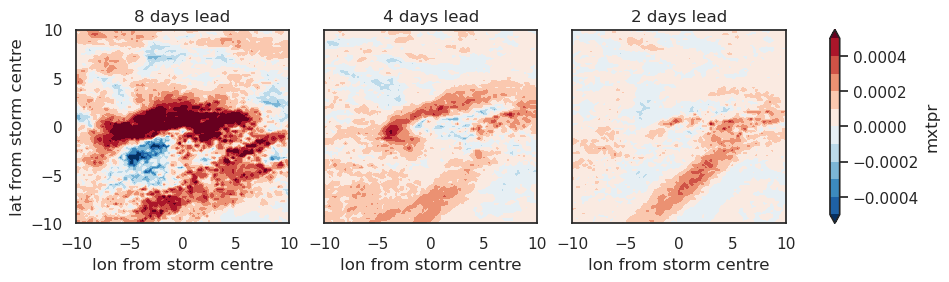

In [14]:
cplot = (incr_storms.mxtpr.sel(timestep=0).mean('number').squeeze() - pi_storms.mxtpr.sel(timestep=0).mean('number').squeeze()).sortby('inidate').plot.contourf(col='inidate',levels=np.linspace(-0.0005,0.0005,11))

cplot.axes[0,0].set_title('8 days lead')
cplot.axes[0,1].set_title('4 days lead')
cplot.axes[0,2].set_title('2 days lead')

cplot.axes[0,0].set_xlabel('lon from storm centre')
cplot.axes[0,1].set_xlabel('lon from storm centre')
cplot.axes[0,2].set_xlabel('lon from storm centre')
cplot.axes[0,0].set_ylabel('lat from storm centre')

# Analysis of model spread

In [ ]:
ifs_eunice_list_stats = ifs_eunice_list.loc[ifs_eunice_list.inidate.isin(['2022-02-10','2022-02-14','2022-02-16'])].groupby(['experiment','inidate','number','track_id']).agg(dict(msl=min,date=min,vo=max)).reset_index()
ifs_eunice_list_stats['date'] = (ifs_eunice_list_stats.date - eunice_filter.date).dt.total_seconds()/(3600*24)

In [ ]:
# Add wind speed maxima
curr_max_winds = curr_storms.ws100.max(dim=['storm_lat','storm_lon', 'timestep'], skipna=True).squeeze().to_dataframe().reset_index()
incr_max_winds = incr_storms.ws100.max(dim=['storm_lat','storm_lon', 'timestep'], skipna=True).squeeze().to_dataframe().reset_index()
pi_max_winds = pi_storms.ws100.max(dim=['storm_lat','storm_lon', 'timestep'], skipna=True).squeeze().to_dataframe().reset_index()

ifs_eunice_list_stats2 = ifs_eunice_list_stats.merge(curr_max_winds, how='outer', on=['inidate', 'experiment', 'number']) # .drop(['number'], axis=1)

In [ ]:
ifs_eunice_list_stats2 = ifs_eunice_list_stats2.merge(incr_max_winds, how='outer')
ifs_eunice_list_stats2 = ifs_eunice_list_stats2.merge(pi_max_winds, how='outer')
ifs_eunice_list_stats2['vo'] = ifs_eunice_list_stats2['vo']*10**6
ifs_eunice_list_stats2['msl'] = ifs_eunice_list_stats2['msl']/100

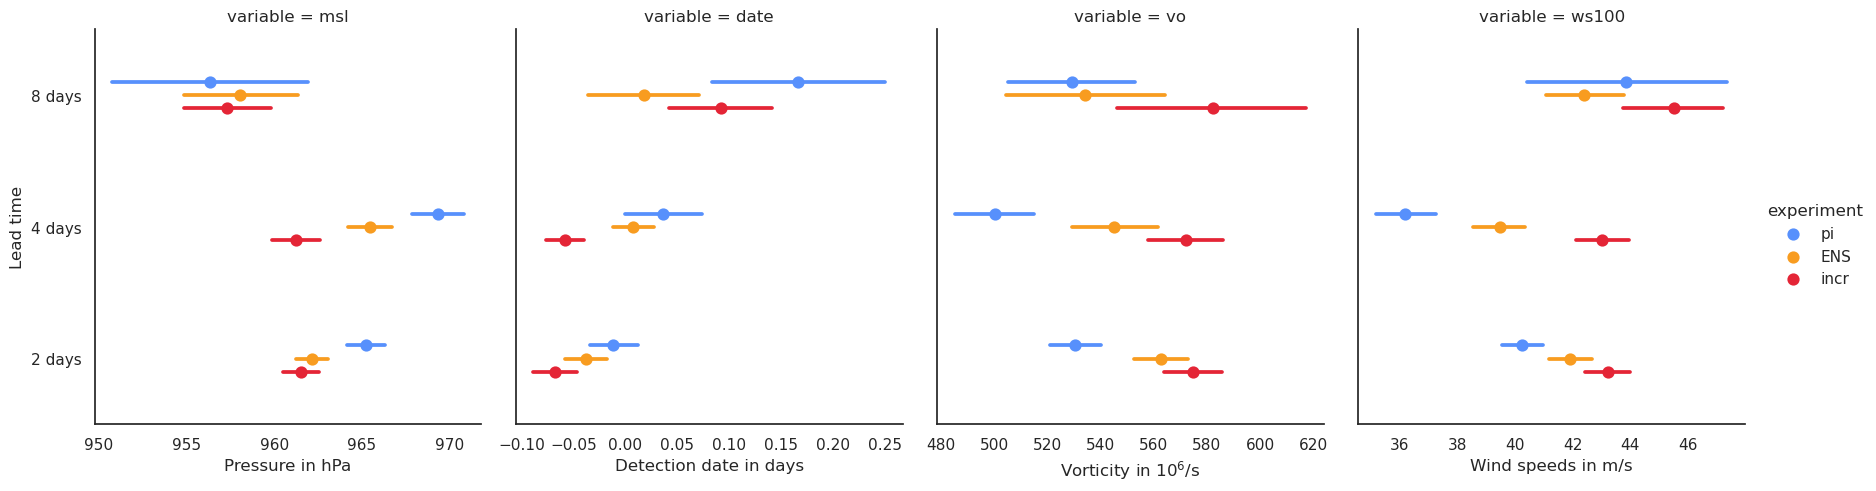

In [145]:
g = sns.catplot(data=ifs_eunice_list_stats2.set_index(['experiment','inidate']).drop(['track_id', 'number'], axis=1).stack().astype(float).reset_index().rename({'level_2':'variable',0:'value'}, axis=1),
           x='value',
           col='variable',
           y='inidate',
           hue='experiment',
           hue_order=['pi','ENS','incr'],
           palette=get_palette.Petroff6().to_sn_palette(),
           kind='point',
           join=False,
           dodge=0.2,
           errorbar=('ci',66),
           n_boot=10000,
           sharex=False)

g.axes[0,0].set_ylabel('Lead time')

inidates = ['8 days', '4 days', '2 days']
g.axes[0,0].set_yticklabels(inidates)

g.axes[0,0].set_xlabel('Pressure in hPa')
g.axes[0,1].set_xlabel('Change in detection date in days')
g.axes[0,2].set_xlabel(r'Vorticity in 10$^{-6}$/s')
g.axes[0,3].set_xlabel('Wind speeds in m/s')

g.axes[0,0].set_title('Mean sea level pressure')
g.axes[0,1].set_title('Detection date')
g.axes[0,2].set_title(r'Vorticity')
g.axes[0,3].set_title('Wind speeds')

plt.savefig('figures/10_surface_langrangians_stats.png')
plt.savefig('figures/10_surface_langrangians_stats.pdf')

In [34]:
def extract_last_elements(array):
    last_elements = []
    for tup in array:
        last_elements.append(tup[-1])
    return last_elements

In [ ]:
# ifs_eunice_list.loc[ifs_eunice_list.groupby('track_id')['vo'].idxmax()]

peak_vo = ifs_eunice_list.groupby(['inidate','experiment','number','track_id'])['vo'].rolling(3).mean().groupby(['inidate','experiment','number','track_id']).idxmax()
peak_vo_datetime = pd.DataFrame(data={'inidate':ifs_eunice_list.inidate[extract_last_elements(peak_vo)],
                                      'experiment': ifs_eunice_list.experiment[extract_last_elements(peak_vo)],
                                      'number': ifs_eunice_list.number[extract_last_elements(peak_vo)],
                                      'track_id': ifs_eunice_list.track_id[extract_last_elements(peak_vo)],
                                      'peak_date': ifs_eunice_list.date[extract_last_elements(peak_vo)]})
merged_df = ifs_eunice_list.merge(peak_vo_datetime, how='left', on=['inidate', 'experiment', 'number', 'track_id'])
merged_df['date_difference'] = merged_df['date'] - merged_df['peak_date']
# peak_vo_relative_time = merged_df['date_difference'].copy()

In [ ]:
def get_ws100_track(field, track):
    ws_df = field.ws100.rename({'timestep':'date'}).to_dataframe().reset_index()
    return pd.merge(track,ws_df, on=['inidate', 'date', 'number'])
    # ws = []
    # for idx in range(len(track)):
    #     ws.append(field.sel(timestep=track.date[idx], number=track.number[idx], inidate=track.inidate[idx]).ws100.max())
    # return track.assign(ws100=ws)
    